# Content-based recommendation model with LGBM Regressor

We will build a _content-based recommendation_ model to recommend movies, this type of model uses the information about what the user likes to recommend similar items, it requires knowledge of the previous actions of the user and knowledge of about the items (features). 

Differently from _Collaborative Filtering_ that recommends items to a user based on the preferences and behaviors of users who are similar to that user, content-based doesn't use any information of other users. In this sense some level of hand-engineering is required to build the feature representations for the model, we have information on the movies to build these features.

This type of model model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in, this is very suited for movie recommendations, since users can have very specific tastes. Also since the model doesn't need any data about other users, it makes it easier to scale to a large number of users which is our case. For these reasons we chose this approach.

In this tutorial, we will comprehensively cover the entire data science pipeline, starting from data acquisition, preprocessing, and visualization, to feature extraction, model building, evaluation, and interpretation.

## 1 Preparation

### 1.1 Install and import necessary libraries

In [70]:
!pip install pandas
!pip install numpy
!pip install lightgbm
!pip install matplotlib

^C
Traceback (most recent call last):
  File "/home/pietro/miniconda3/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
  File "/home/pietro/miniconda3/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/home/pietro/miniconda3/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
import matplotlib.pyplot as plt

### 1.2 Download and extract Movie dataset

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [ ]:
#Extract the file
!unzip archive.zip

Archive:  archive.zip
replace credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

The dataset consists of the following files:

- movies_metadata.csv: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- keywords.csv: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- credits.csv: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

- links.csv: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

- links_small.csv: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- rating.csv: The Full MovieLens Dataset consisting of 26 million ratings and 750,000 tag applications from 270,000 users on all the 45,000 movies in this dataset can be accessed here

- ratings_small.csv: The subset of 100,000 ratings from 700 users on 9,000 movies.

We will not be using neither the cast information for our model as the large number of possible actors and crew would greatly increase the complexity of the model. We will also not use keywords but one could use for example a word2vec approach to turn these words into feature vectors for a recommendation model.

### 1.3 Preprocess the data

We here create the relevant databases from our data, selecting information that we will be using, that is: movie name, year, genre and ratings from users.

In [44]:
#Load files

df_ratings = pd.read_csv('ratings.csv')
df_movies_metadata = pd.read_csv('movies_metadata.csv')

/tmp/ipykernel_38066/482096670.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies_metadata = pd.read_csv('movies_metadata.csv')


In [59]:
#df_movies_metadata[~(df_movies_metadata['budget']=='0')]
# We see that the budget is missing on a lot of movies, so we wont use this for our model

# As said before we also wont use informations like overview and tagline since this would involve processing text via NLP techniques
df_movies_metadata = df_movies_metadata[['genres','release_date','title']]

#Get year release
df_movies_metadata['year'] = df_movies_metadata['release_date'].str[:4]
df_movies_metadata = df_movies_metadata[~df_movies_metadata['year'].isna()]
df_movies_metadata = df_movies_metadata.astype({'year':'int'})

# We will create a table for movie genres
genre_df_list = []
# Iterate over each row in the original DataFrame
for movie_index, row in df_movies_metadata.iterrows():
    # Convert genres from string to list of dictionaries
    genres_list = eval(row['genres'])

    # Iterate over each genre in the list and append to the new DataFrame
    for genre_dict in genres_list:
        genre_df_list.append({'movieId': movie_index, 'genre': genre_dict['name']})
genres_df = pd.DataFrame(genre_df_list)
# genres_df.index = genres_df.index + 1

movies_df = df_movies_metadata[['year','title']]
movies_df = movies_df[~movies_df.isna()['title']]
movies_df = movies_df.reset_index(names='movieId')
# movies_df = movies_df[movies_df.index.isin(genres_df.groupby('movieId').sum().index)] #get only movies we have genre information

# ratings_df = df_ratings[df_ratings['movieId'].isin(genres_df.groupby('movieId').sum().index)] #get only ratings we have genre information
df_ratings['movieId'] -= 1
ratings_df = df_ratings[df_ratings['movieId'].isin(movies_df['movieId'])] #get only ratings we have information

## 2 Visualization

Mean number of ratings: 81.91753051608356 
Median number of ratings: 26.0


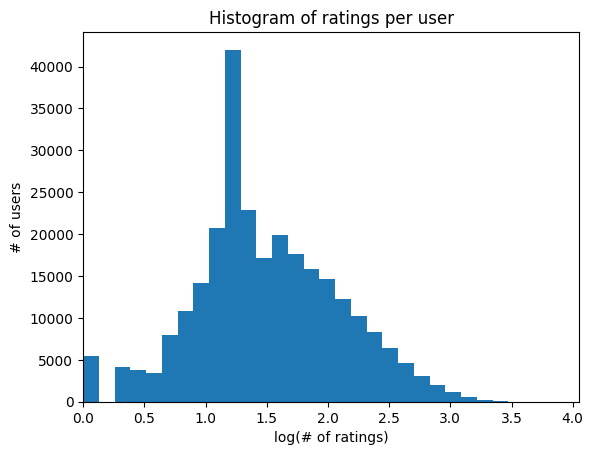

In [73]:
plt.hist(np.log10(ratings_df['userId'].value_counts().to_numpy()), bins=30)
plt.xlim(0)
plt.xlabel('log(# of ratings)')
plt.ylabel('# of users')
plt.title("Histogram of ratings per user")
print("Mean number of ratings: {} \nMedian number of ratings: {}".format(ratings_df['userId'].value_counts().mean(),ratings_df['userId'].value_counts().median()))

Mean number of ratings: 2003.3782778332275 
Median number of ratings: 222.0


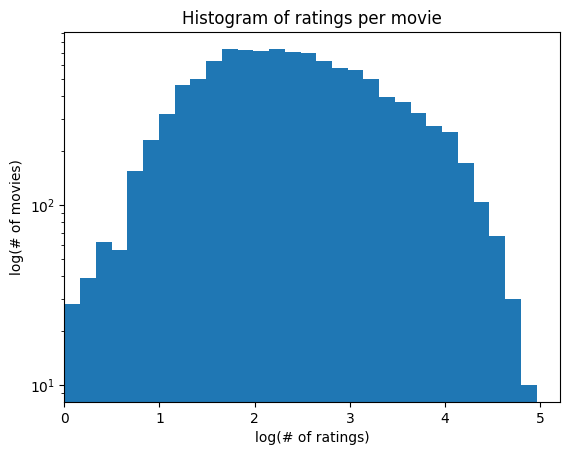

In [74]:
plt.hist(np.log10(ratings_df['movieId'].value_counts().to_numpy()), bins=30)
plt.xlim(0)
plt.yscale('log')
plt.xlabel('log(# of ratings)')
plt.ylabel('log(# of movies)')
plt.title("Histogram of ratings per movie")
print("Mean number of ratings: {} \nMedian number of ratings: {}".format(ratings_df['movieId'].value_counts().mean(),ratings_df['movieId'].value_counts().median()))

## 3 Model training

### 3.1 Temporal train-valid split per user

We will reduce the number of users and for each users take: 80% oldest ratings in the training set, 20% newest ratings in the validation set

In [75]:
#Limit size of rating dataset
user_35 = (ratings_df['userId'].value_counts()>35)
user_sample = user_35[user_35].sample(n=15000).index
ratings_df = ratings_df[ratings_df['userId'].isin(user_sample)]

#Create training mask
train_th = ratings_df.groupby('userId')['timestamp'].quantile(0.8)
train_th = pd.merge(ratings_df[['userId']], train_th, how='left',
                        left_on='userId', right_index=True)['timestamp']
mask_train = ratings_df['timestamp'] < train_th
print(mask_train.mean())

#Split feature(X) and target(Y)
y = ratings_df['rating'].copy()
x = ratings_df.drop(columns=['rating'])

# Split training
# mask_train_likes = (mask_train & (y >= 4.)).to_numpy()
# x_train = x.loc[mask_train]

0.7945344470840677


### 3.2 Craft movies features

In [76]:
genres_dummies = pd.get_dummies(genres_df)
genres_dummies = genres_dummies.groupby('movieId').sum().reset_index()

x_movies = pd.merge(movies_df[['year', 'movieId']], genres_dummies, on = 'movieId', how='left').fillna(0)
movie_counts = x[mask_train]['movieId'].value_counts()
x_movies['popularity'] = x_movies['movieId'].map(movie_counts).fillna(0)

x_movie_feat = pd.merge(x, x_movies, how='left', on='movieId').fillna(0)

In [77]:
x_movie_feat[x_movie_feat['movieId']==0]

,userId,movieId,timestamp,year,genre_Action,genre_Adventure,genre_Animation,genre_Aniplex,genre_BROSTA TV,genre_Carousel Productions,...,genre_Science Fiction,genre_Sentai Filmworks,genre_TV Movie,genre_Telescene Film Group Productions,genre_The Cartel,genre_Thriller,genre_Vision View Entertainment,genre_War,genre_Western,popularity
0,12,0,943912205,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
368,74,0,862777274,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
511,94,0,965798694,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
582,98,0,1115067736,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
795,105,0,1238416812,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608138,270751,0,1116765321,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
2608543,270769,0,954372959,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
2609274,270817,0,900677145,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0
2609487,270868,0,1453408926,1995,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5915.0


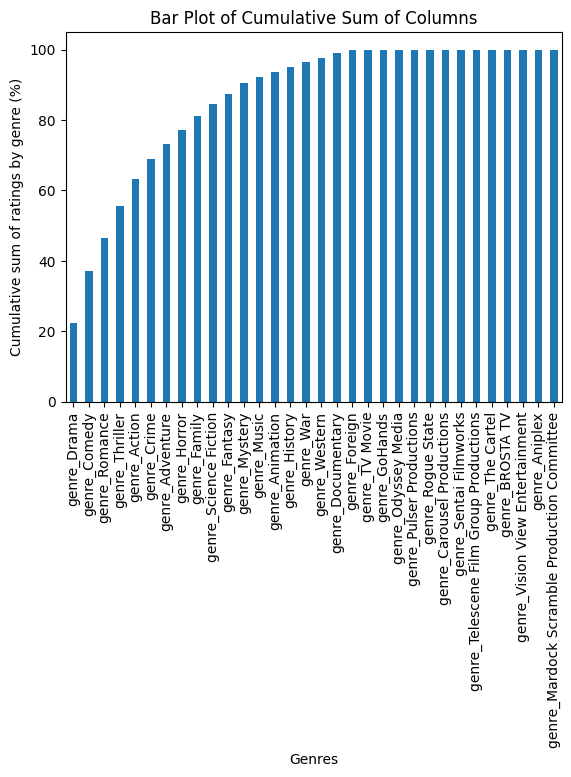

More than 99% of ratings belong to the first 19 most watched genres


In [78]:
ratings_genres = x_movie_feat.sum().filter(like='genre').sort_values(ascending=False)
ratings_genres = ratings_genres.cumsum()/ratings_genres.sum()*100

# Create a bar plot with cumulative values
ratings_genres.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Genres')
plt.ylabel('Cumulative sum of ratings by genre (%)')
plt.title('Bar Plot of Cumulative Sum of Columns')
plt.show()

n_top_genres = (ratings_genres.reset_index(drop=True)>99).idxmax()+1
print('More than 99% of ratings belong to the first {} most watched genres'.format(n_top_genres))
top_ratings_genres = ratings_genres.iloc[:n_top_genres].index
not_top_ratings_genres = ratings_genres.iloc[n_top_genres:].index

### 3.2 Craft user features

In [79]:
x_movie_feat = x_movie_feat.drop(columns = not_top_ratings_genres)
x_train = x_movie_feat.loc[mask_train.reset_index(drop=True)]

# Add "average liked genres":
# cols = [col for col in x.columns if 'genre' in col]
cols = [col for col in top_ratings_genres if 'genre' in col]
x_users = x_train[['userId'] + cols].groupby('userId').mean()
x_users = x_users.rename(columns={col: f'user_{col}' for col in cols})
x_users /= x_users.sum(axis=1).to_numpy().reshape(-1, 1)
x_users = x_users.reset_index()
x_users

# A years quantiles of liked movies:
x_train['year'] = pd.to_numeric(x_train['year'], errors='coerce')
def add_quantiles(x_users, col, qs):
    quantiles = x_train.groupby('userId')[col].quantile(qs)
    df = quantiles.reset_index().pivot(index='userId', columns='level_1', values=col)
    return pd.merge(
        x_users,
        df.reset_index().rename(columns={q: f'{col}_{q}' for q in qs}),
        validate='1:1'
    )
x_users = add_quantiles(x_users, 'year', [0.1, 0.25, 0.5, 0.75, 0.9])
x_users = add_quantiles(x_users, 'popularity', [0.1, 0.25, 0.5, 0.75, 0.9])

/tmp/ipykernel_38066/164416377.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['year'] = pd.to_numeric(x_train['year'], errors='coerce')


In [80]:
assert 'userId' in x_users
x_user_feat = pd.merge(x_movie_feat, x_users, on='userId', how='left', validate='m:1').fillna(0)
x_user_feat

,userId,movieId,timestamp,year,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,...,year_0.1,year_0.25,year_0.5,year_0.75,year_0.9,popularity_0.1,popularity_0.25,popularity_0.5,popularity_0.75,popularity_0.9
0,12,0,943912205,1995,0.0,0.0,1.0,1.0,0.0,0.0,...,1953.0,1982.0,1993.0,1996.0,1998.0,168.2,363.0,1082.0,2523.00,4920.0
1,12,15,943913329,1995,0.0,0.0,0.0,0.0,1.0,0.0,...,1953.0,1982.0,1993.0,1996.0,1998.0,168.2,363.0,1082.0,2523.00,4920.0
2,12,16,943911191,1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1953.0,1982.0,1993.0,1996.0,1998.0,168.2,363.0,1082.0,2523.00,4920.0
3,12,28,943913115,1995,0.0,1.0,0.0,0.0,0.0,0.0,...,1953.0,1982.0,1993.0,1996.0,1998.0,168.2,363.0,1082.0,2523.00,4920.0
4,12,31,943911150,1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1953.0,1982.0,1993.0,1996.0,1998.0,168.2,363.0,1082.0,2523.00,4920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609795,270894,8958,1419820707,1990,0.0,0.0,0.0,1.0,0.0,0.0,...,1957.5,1975.5,1989.0,1994.0,1998.0,207.0,1099.0,2520.0,4034.25,5742.5
2609796,270894,27772,1419820876,1946,0.0,0.0,0.0,0.0,0.0,0.0,...,1957.5,1975.5,1989.0,1994.0,1998.0,207.0,1099.0,2520.0,4034.25,5742.5
2609797,270894,33678,1419820518,2014,0.0,0.0,0.0,0.0,0.0,0.0,...,1957.5,1975.5,1989.0,1994.0,1998.0,207.0,1099.0,2520.0,4034.25,5742.5
2609798,270894,34404,1419820505,2011,0.0,0.0,0.0,0.0,0.0,0.0,...,1957.5,1975.5,1989.0,1994.0,1998.0,207.0,1099.0,2520.0,4034.25,5742.5


### 3.3 Train a model

In [82]:
# We are training a content-based model, the model should not learn anything about the user id or the movie id
x_CB = x_user_feat.drop(columns=['userId', 'movieId', 'timestamp'])

#Split train and valid datasets
mask_train_reset = mask_train.reset_index(drop=True)
X_train = x_CB.loc[mask_train_reset]
X_valid = x_CB.loc[~mask_train_reset]
y_train = y[mask_train].to_numpy()
y_valid = y[~mask_train].to_numpy()

In [135]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(
    num_leaves=80,
    max_depth=-1,
    learning_rate=0.4,
    n_estimators=150,
    reg_alpha=0.2,
    # reg_lambda=0.3
)

subsampling_fraction = 1.0
mask = np.random.rand(len(X_train)) < subsampling_fraction
X_train_subsample = X_train.iloc[mask]
y_train_subsample  = y_train[mask]
model.fit(X_train_subsample, y_train_subsample)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7224
[LightGBM] [Info] Number of data points in the train set: 2073576, number of used features: 50
[LightGBM] [Info] Start training from score 3.541400


LGBMRegressor(learning_rate=0.4, n_estimators=150, num_leaves=80, reg_alpha=0.2)

### 4 Compute RMSE and compare to a dummy baseline

In [136]:
preds = model.predict(X_valid)

# valid RMSE:
error = preds - y_valid
rmse_model = np.sqrt((error ** 2).mean())
# dummy baseline RMSE:
rmse_dumm = np.sqrt(((y_train_subsample.mean() - y_valid) ** 2).mean())

print('RMSE of model: {}\nRMSE of dummy baseline: {}'.format(rmse_model, rmse_dumm))

RMSE of model: 0.8950147125120325
RMSE of dummy baseline: 1.0458930834279283


/tmp/ipykernel_38066/3073181802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_user_feat_train['error'] = error
/home/pietro/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_38066/3073181802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_user_feat_train['log_popularity'] = np.log10(x_user_feat_train['popularity'])
/tmp/ipykernel_38066/3073181802.py:5: Sett

(0.0, 3.9745056019734397)

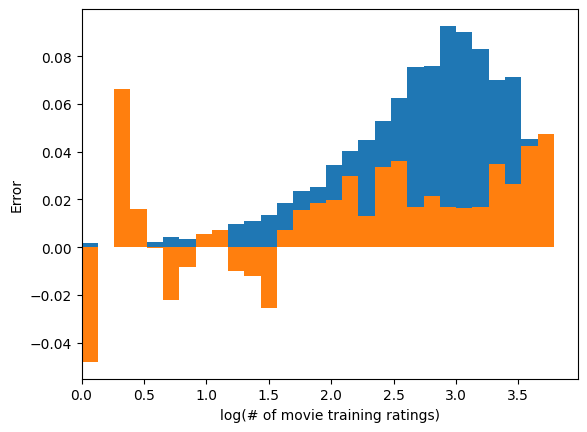

In [450]:
x_user_feat_train = x_user_feat.loc[~mask_train_reset]
x_user_feat_train['error'] = error
x_user_feat_train['log_popularity'] = np.log10(x_user_feat_train['popularity'])
quant = (np.log10(movie_counts.max())-np.log10(movie_counts.min()))*(np.arange(31)/30)
x_user_feat_train['rating_count_interval'] = pd.cut(x_user_feat_train['log_popularity'], bins=quant.tolist(), include_lowest=True, labels=False)
error_per_rating = x_user_feat_train.groupby('rating_count_interval').mean()['error']
error_per_rating = pd.merge(pd.DataFrame(quant+(quant[1]-quant[0])/2), error_per_rating, left_index=True, right_index=True, how='left').fillna(0).iloc[:-1]
error_per_rating = pd.merge(error_per_rating, x_user_feat_train['rating_count_interval'].value_counts(), left_index=True, right_index=True, how='left').fillna(0).iloc[:-1]

fig, ax = plt.subplots()
bars2 = ax.bar(error_per_rating[0], error_per_rating['count']/error_per_rating.sum()['count'], width=quant[1]-quant[0])
ax.set_xlabel('log(# of movie training ratings)')
ax.set_ylabel('Error')
ax.set_xlim(0)

# fig, ax = plt.subplots()
bars = ax.bar(error_per_rating[0], error_per_rating['error'], width=quant[1]-quant[0])
ax.set_xlabel('log(# of movie training ratings)')
ax.set_ylabel('Error')
ax.set_xlim(0)


Text(0, 0.5, 'Error')

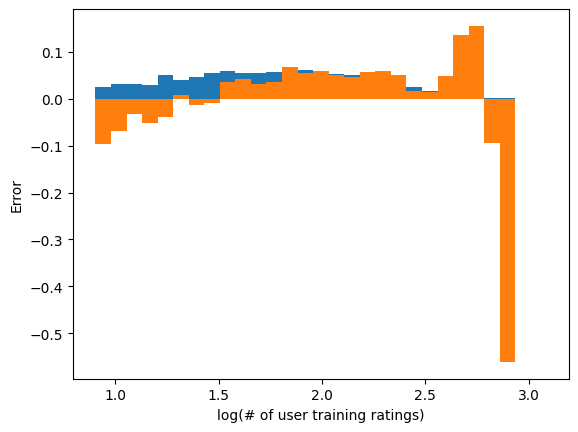

In [451]:
x_user_feat_train = pd.merge(x_user_feat_train, x_user_feat_train['userId'].value_counts(), on='userId', how='left')
x_user_feat_train['log_user_ratings'] = np.log10(x_user_feat_train['count'])
quant = (np.log10(x_user_feat_train['count'].max())-np.log10(x_user_feat_train['count'].min()))*(np.arange(31)/30)+ np.log10(x_user_feat_train['count'].min())
x_user_feat_train['user_rating_interval'] = pd.cut(x_user_feat_train['log_user_ratings'], bins=quant.tolist(), include_lowest=True, labels=False)
error_per_user = x_user_feat_train.groupby('user_rating_interval')['error'].mean()
error_per_user = pd.merge(pd.DataFrame(quant+(quant[1]-quant[0])/2), error_per_user, left_index=True, right_index=True, how='left').fillna(0).iloc[:-1]
error_per_user = pd.merge(error_per_user, x_user_feat_train['user_rating_interval'].value_counts(), left_index=True, right_index=True, how='left').fillna(0).iloc[:-1]

fig, ax = plt.subplots()
bars = ax.bar(error_per_user[0], error_per_user['count']/error_per_user.sum()['count'], width=quant[1]-quant[0])
ax.set_xlabel('log(# of user training ratings)')
ax.set_ylabel('Error')

bars = ax.bar(error_per_user[0], error_per_user['error'], width=quant[1]-quant[0])
ax.set_xlabel('log(# of user training ratings)')
ax.set_ylabel('Error')